### Import Libraries

In [1]:
from textwrap import dedent
from scipy.stats import norm as norm_distribution
import numpy as np
from div0 import div0
from scipy import interp
import scipy.integrate as integrate

### Plotting Preferences

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Global Parameters

In [3]:
beta = 0.95
b = 0.20+0.08+0.078 #Contributions: equals 0.358
f = 0.50*0.08 #FGTS and firing fine: equals 0.04

### Grid Parameters

In [4]:
T_max = 360 #divide by 10 to get the number of months
sp = 3
st = 0.1

### Occupation Parameters

In [5]:
T_1 = 0
T_2 = 30
y_0 = -1
sig2_0 = 2
sig2_star = 1

### Match Level Variables

In [6]:
w = 40
H_0 = norm_distribution(y_0+(w/10), sig2_0**(0.5))
h_0 = H_0.pdf
y_star = H_0.rvs(1)

### Grid Setup

In [7]:
n = 1
y = np.arange((y_0+w/10)-(np.ceil(100*(sig2_0)**(0.5))/100)*sp, 
             (y_0+w/10)+(np.ceil(100*(sig2_0)**(0.5))/100)*sp, st)
t = np.arange(1, T_max+1, 1) #note that t starts at one

mu_grid = np.array([((sig2_0)/(t*sig2_0+sig2_star))*y_star+(((t-1)*sig2_0+sig2_star)/(t*sig2_0+sig2_star))*k for k in y]).reshape(n,y.size,T_max)
mu_grid = np.c_[np.repeat(y_0+(w/10),y.size).reshape(1,y.size,1), mu_grid] #include priors
sigma_grid = np.tile(((sig2_0)/(t*sig2_0+sig2_star))**(0.5)*sig2_star, (n,y.size,1))
sigma_grid = np.c_[np.repeat(sig2_0,y.size).reshape(1,y.size,1), sigma_grid] #include priors
h_grid = np.array([norm_distribution(i,j**(0.5)).pdf for i, j in zip(mu_grid.flatten(),sigma_grid.flatten())])

### Tenure Variables

In [8]:
xi = norm_distribution.rvs(y_star, sig2_star**(0.5), T_max) #not necessary for VFI
R = xi-w/10 #not necessary for VFI
c = np.hstack((np.array(0.5*(T_1-t[t<=T_1])*(w/10)), np.array(0.5*(T_2-t[(t>T_1)&(t<=T_2)])*(w/10)), np.array(w*(1+b+f*((t[t>T_2]+10)/10)))))
costs = np.array([np.tile(c,(y.size,1)) for k in range(n)])
costs = np.c_[np.repeat(0,y.size).reshape(1,y.size,1), costs] #include period zero

### Firing Cost Schedule

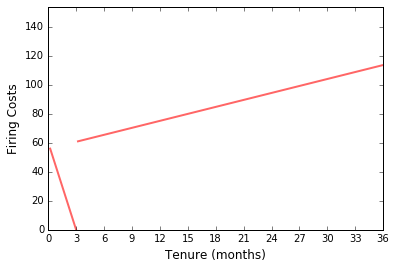

In [9]:
fig, ax = plt.subplots()
x1 = t[0:T_1]
x2 = t[T_1+1:T_2]
x3 = t[T_2+1:T_max]
z1 = c[0:T_1]
z2 = c[T_1+1:T_2]
z3 = c[T_2+1:T_max]
ax.set_ylim(0, np.ceil(max(c))+40)
ax.plot(x1, z1, 'r-', linewidth=2, alpha=0.6)
ax.plot(x2, z2, 'r-', linewidth=2, alpha=0.6)
ax.plot(x3, z3, 'r-', linewidth=2, alpha=0.6)

ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Firing Costs', fontsize=12)

ax.set_xlim(0,T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, T_max+1, (T_max+1)/30+1), labels)
plt.show()

### Iterative Variables

In [10]:
#not necessary for VFI
y_t = np.empty(t.size)
for x in t:
    if t[x-1]==1: #add w/10 to y_0
        y_t[x-1]=(((x-1)*sig2_0+sig2_star)/(x*sig2_0+sig2_star))*(y_0+w/10)+(sig2_0/(x*sig2_0+sig2_star))*xi[x-1]
    else:         #don't add w/10 to y_{t-1}
        y_t[x-1]=(((x-1)*sig2_0+sig2_star)/(x*sig2_0+sig2_star))*(y_t[x-2])+(sig2_0/(x*sig2_0+sig2_star))*xi[x-1]
        
sig2_t = (sig2_0*sig2_star)/((t*sig2_0)+sig2_star)

In [11]:
#Beliefs for tomorrow conditional on today
#not necessary for VFI
mu = ((sig2_0)/(t*sig2_0+sig2_star))*y_star+(((t-1)*sig2_0+sig2_star)/(t*sig2_0+sig2_star))*np.append([y_0+w/10], y_t[0:T_max-1])
sigma = ((sig2_0)/(t*sig2_0+sig2_star))**(0.5)*sig2_star
h_t = np.array([norm_distribution(i,j**(0.5)).pdf for i, j in zip(mu.flatten(),sigma.flatten())])

### Belief Paths and Tradeoffs

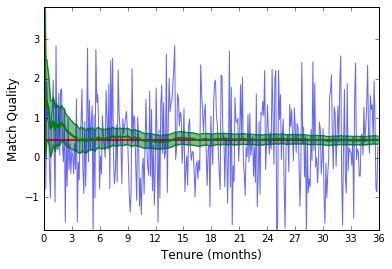

In [12]:
fig, ax = plt.subplots()
x1 = t
z1 = np.repeat(y_star, T_max) #true match quality
z2 = xi #signals
z3 = y_t #beliefs
z4 = y_t+1.96*sig2_t**0.5 #upper CI
z5 = y_t-1.96*sig2_t**0.5 #lower CI

ax.set_ylim(np.ceil(y_star)-2*np.ceil(max(sig2_star,sig2_0))**0.5, np.ceil(y_star)+2*np.ceil(max(sig2_star,sig2_0))**0.5)
ax.plot(x1, z1, 'r-', linewidth=2, alpha=1)
ax.plot(x1, z2, 'b-', linewidth=1, alpha=0.6)
ax.plot(x1, z3, 'g-', linewidth=2, alpha=1)
ax.plot(x1, z4, 'g-', linewidth=1, alpha=1)
ax.plot(x1, z5, 'g-', linewidth=1, alpha=1)

ax.fill_between(x1, z5, z4, color='g', alpha=0.5)

ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Match Quality', fontsize=12)

ax.set_xlim(0,T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, T_max+1, (T_max+1)/30+1), labels)
plt.show()

Note: It may seem inconsistent that $\sigma^2_t$ converges to zero so quickly that the true match quality $y_*$ is not within the 95% confidence interval around the beliefs $y_t$. This is because $y_t$ and $\sigma^2_t$ only describe the present belief regarding the revealed quality. What we care about is the belief about future match quality conditional on what has been observed thus far (see figure below).

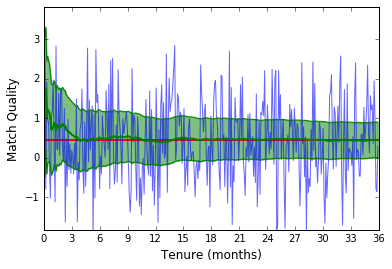

In [13]:
fig, ax = plt.subplots()
x1 = t
z1 = np.repeat(y_star, T_max) #true match quality
z2 = xi #signals
z3 = mu #beliefs for tomorrow
z4 = mu+1.96*sigma**0.5 #upper CI
z5 = mu-1.96*sigma**0.5 #lower CI

ax.set_ylim(np.ceil(y_star)-2*np.ceil(max(sig2_star,sig2_0))**0.5, np.ceil(y_star)+2*np.ceil(max(sig2_star,sig2_0))**0.5)
ax.plot(x1, z1, 'r-', linewidth=2, alpha=1)
ax.plot(x1, z2, 'b-', linewidth=1, alpha=0.6)
ax.plot(x1, z3, 'g-', linewidth=2, alpha=1)
ax.plot(x1, z4, 'g-', linewidth=1, alpha=1)
ax.plot(x1, z5, 'g-', linewidth=1, alpha=1)

ax.fill_between(x1, z5, z4, color='g', alpha=0.5)

ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Match Quality', fontsize=12)

ax.set_xlim(0,T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, T_max+1, (T_max+1)/30+1), labels)
plt.show()

Note: The prior belief $y_0+\frac{w}{10}$ is always included in the initial confidence interval. As time progresses, the mean belief approaches the true belief $y_*$ and the confidence interval shrinks. The tradeoff at any tenure is between the beliefs shown above and a new draw with $h_0=\mathcal{N}\left(y_0+\frac{w}{10},\sigma^2_0\right)$.

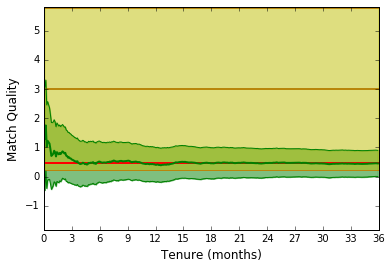

In [14]:
fig, ax = plt.subplots()
x1 = t
z1 = np.repeat(y_star, T_max) #true match quality
z2 = np.repeat(y_0+w/10, T_max) #prior belief
z3 = np.repeat(y_0+w/10+1.96*sig2_0**0.5, T_max) #upper CI
z4 = np.repeat(y_0+w/10-1.96*sig2_0**0.5, T_max) #lower CI
z5 = mu #beliefs for tomorrow
z6 = mu+1.96*sigma**0.5 #upper CI
z7 = mu-1.96*sigma**0.5 #lower CI

ax.set_ylim(np.ceil(min(y_0+w/10,y_star))-2*np.ceil(sig2_0)**0.5, np.ceil(max(y_0+w/10,y_star))+2*np.ceil(sig2_0)**0.5)
ax.plot(x1, z1, 'r-', linewidth=2, alpha=1)
ax.plot(x1, z2, 'darkgoldenrod', linewidth=2, alpha=1)
ax.plot(x1, z3, 'darkgoldenrod', linewidth=1, alpha=1)
ax.plot(x1, z4, 'darkgoldenrod', linewidth=1, alpha=1)
ax.plot(x1, z5, 'g-', linewidth=2, alpha=1)
ax.plot(x1, z6, 'g-', linewidth=1, alpha=1)
ax.plot(x1, z7, 'g-', linewidth=1, alpha=1)

ax.fill_between(x1, z7, z6, color='g', alpha=0.5)
ax.fill_between(x1, z4, z3, color='y', alpha=0.5)

ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Match Quality', fontsize=12)

ax.set_xlim(0,T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, T_max+1, (T_max+1)/30+1), labels)
plt.show()

### Value Function Iteration

In [36]:
#Initial guess (with negative and positive values)
v = np.array([np.ones((n, 1, t.size))*(i-y.size/2) for i in range(y.size)]).reshape(n,y.size,t.size)
#initial guess has value increasing in match beliefs (with negative and positive values)
v = np.c_[np.array([np.ones((n, 1))*(-i+y.size/2) for i in range(y.size)]).reshape(n,y.size,1), v]
#for tenure zero the guess is decreasing in match beliefs (with positive and negative values)
#Initial iteration
new_v = v

In [37]:
#REPEAT UNTIL CONVERGENCE
#...code should use v instead of new_v in the v_cols formula 

#Piecewise linear interpolation functions f(y): value as a function of the belief grid
#...represents the (converging) value assigned V(y',t+1) at each grid column (:,t)
#...loops are necessary due to list comprehension issues with lambda functions
#Columns from 0 to T_max (with T_max duplicate)
v_cols = np.empty(n*y.size*(t.size+1), dtype=object)
it=0
for k in range(n):
    v_cols0 = np.array([(lambda z: (lambda x: interp(x, y, z)))(new_v[k,:,0])])
    for i in range(y.size):
        for j in range(t.size+1):
            if j != T_max: #from 0 to (T_max-1)
                v_cols[it] = np.array([(lambda z: (lambda x: interp(x, y, z)))(new_v[k,:,(j+1)])])
            else:          #T_max duplicate
                v_cols[it] = np.array([(lambda z: (lambda x: interp(x, y, z)))(new_v[k,:,j])])
            it = it+1

#Keep worker
#...E[V(y',t+1)]: integrate value function with density h_grid (include 95% CI in integral bounds)
E0 = np.array([integrate.fixed_quad(lambda x: v_cols[l][0](x)*h_grid[l](x), i-3*j**0.5, i+3*j**0.5)[0] for l, (i, j) in enumerate(zip(mu_grid.flatten(),sigma_grid.flatten()))]).reshape(n,y.size,t.size+1)
v0 = beta*E0

#Fire worker
#...E[V(y',0)]: integrate value function with density h_0 (include 95% CI in integral bounds)
E1 = np.array([integrate.fixed_quad(lambda x: v_cols0[0](x)*h_0(x), y_0+w/10-3*sig2_0**0.5, y_0+w/10+3*sig2_0**0.5)[0] for l in range(n) for (i, j) in enumerate(zip(mu_grid.flatten(),sigma_grid.flatten()))]).reshape(n,y.size,t.size+1)
v1 = -costs + beta*E1

In [38]:
#UPDATE AFTER EACH REPEAT TO APPROACH CONVERGENCE
#...put in separate line because setting new_v affects v_cols functions
new_v = np.maximum(v0, v1)

### Checks on VFI

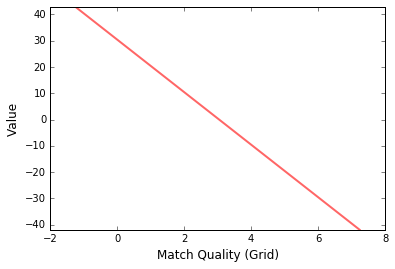

In [39]:
fig, ax = plt.subplots()
x = y
z = v_cols0[0](x)
ax.set_ylim(np.amin(v_cols0[0](x)), np.amax(v_cols0[0](x)))
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
plt.show()

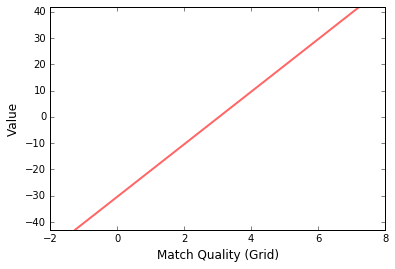

In [40]:
### v_cols: functions that will be integrated with density h_grid or h_0 [varies with each iteration]
q = 0 #change q from 0 to y.size to look at the increasing mean and same variance
r = 0 #change r from 0 to t.size to look at different tenures
fig, ax = plt.subplots()
x = y
z = v_cols[q*(T_max+1)+r][0](x)
ax.set_ylim(np.amin(v_cols[q*(T_max+1)+r][0](x)), np.amax(v_cols[q*(T_max+1)+r][0](x)))
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
plt.show()

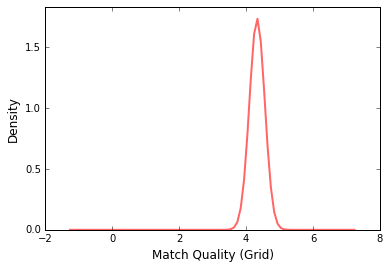

In [41]:
### h_grid: density from beliefs about future quality by grid point when deciding to keep the worker
q = 56 #change q from 0 to y.size to look at the increasing mean and same variance
r = 360 #change r from 0 to t.size to look at different tenures
fig, ax = plt.subplots()
x = y
z = h_grid[q*(T_max+1)+r](x)
ax.set_ylim(np.amin(h_grid[q*(T_max+1)+r](x)), np.amax(h_grid[q*(T_max+1)+r](x))+0.1)
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.show()

Note: Near the edge of the grid, the density for keeping a match is cut. To my knowledge, however, this does not affect the integration. The important thing is to have good integration bounds.

In [42]:
#Integration Check
q = 0 #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
int1 = integrate.fixed_quad(lambda x: v_cols[q*(T_max+1)+r][0](x)*h_grid[q*(T_max+1)+r](x), mu_grid.flatten()[q*(T_max+1)+r]-3*sigma_grid.flatten()[q*(T_max+1)+r]**0.5, mu_grid.flatten()[q*(T_max+1)+r]+3*sigma_grid.flatten()[q*(T_max+1)+r]**0.5)[0]
q = 28
int2 = integrate.fixed_quad(lambda x: v_cols[q*(T_max+1)+r][0](x)*h_grid[q*(T_max+1)+r](x), mu_grid.flatten()[q*(T_max+1)+r]-3*sigma_grid.flatten()[q*(T_max+1)+r]**0.5, mu_grid.flatten()[q*(T_max+1)+r]+3*sigma_grid.flatten()[q*(T_max+1)+r]**0.5)[0]
q = 56
int3 = integrate.fixed_quad(lambda x: v_cols[q*(T_max+1)+r][0](x)*h_grid[q*(T_max+1)+r](x), mu_grid.flatten()[q*(T_max+1)+r]-3*sigma_grid.flatten()[q*(T_max+1)+r]**0.5, mu_grid.flatten()[q*(T_max+1)+r]+3*sigma_grid.flatten()[q*(T_max+1)+r]**0.5)[0]
[int1, int2, int3]

[-41.622609556958395, -15.444856005964532, 11.791353784078984]

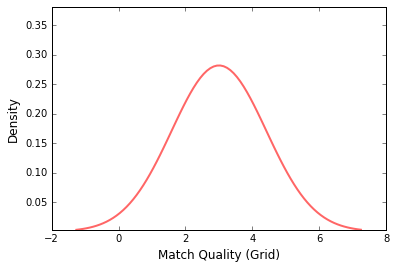

In [43]:
### h_0: density from beliefs about future quality when drawing a new worker
#...this is the prior and does not vary with the grid location
fig, ax = plt.subplots()
x = y
z = h_0(x)
ax.set_ylim(np.amin(h_0(x)), np.amax(h_0(x))+0.1)
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.show()

In [44]:
#Integration Check (flat in q and in r)
q = 0 #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
int1 = integrate.fixed_quad(lambda x: v_cols[q*(T_max+1)+r][0](x)*h_0(x), (y_0+w/10-3*sig2_0**0.5), (y_0+w/10+3*sig2_0**0.5))[0]
q = 28 
int2 = integrate.fixed_quad(lambda x: v_cols[q*(T_max+1)+r][0](x)*h_0(x), (y_0+w/10-3*sig2_0**0.5), (y_0+w/10+3*sig2_0**0.5))[0]
q = 56 
int3 = integrate.fixed_quad(lambda x: v_cols[q*(T_max+1)+r][0](x)*h_0(x), (y_0+w/10-3*sig2_0**0.5), (y_0+w/10+3*sig2_0**0.5))[0]
[int1, int2, int3]

[-0.40227815912659287, -0.40227815912659287, -0.40227815912659287]

In [45]:
#Value of Keep
q = 0 #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
int1 = v0[0,q,r]
q = 28 
int2 = v0[0,q,r]
q = 56 
int3 = v0[0,q,r]
[int1, int2, int3]

[-39.541479079110474, -14.672613205666304, 11.201786094875034]

In [46]:
#Value of Fire (flat in q, decreasing in r)
q = q #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
int1 = v1[0,q,r]
q = 28 
int2 = v1[0,q,r]
q = 56 
int3 = v1[0,q,r]
[int1, int2, int3]

[0.3821642511702632, 0.3821642511702632, 0.3821642511702632]

In [47]:
#New Value
q = 0 #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
int1 = np.maximum(v0[0,q,r], v1[0,q,r])
q = 28 
int2 = np.maximum(v0[0,q,r], v1[0,q,r])
q = 56
int3 = np.maximum(v0[0,q,r], v1[0,q,r])
[int1, int2, int3]

[0.3821642511702632, 0.3821642511702632, 11.201786094875034]